# Unsupervised Gaussian Mixture Model

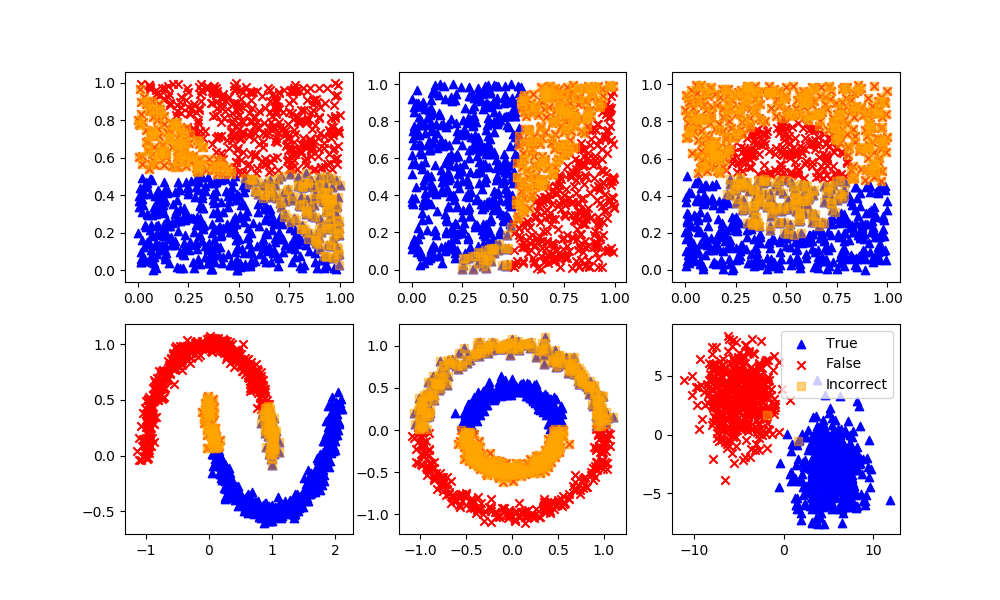

**Links:**\
[Anomaly IDS Using GMM](https://ieeexplore.ieee.org/document/4682192)\
[Scikit-Learn GMM](https://scikit-learn.org/stable/modules/mixture.html)

**Definition**\
A Gaussian mixture model is a probabilistic model that assumes all data points are generated from a mixture of several Gaussian distributions. Each Gaussian distribution represents a cluster, GMM tries to find the parameters of these distributions.

The parameters of the Gaussian distribution are as such:
- **Mean:** The center of each distribution.
- **Covariance:** The shape and orientation, it describes how the data points are spread about the mean.
- **Mixing Probabilities:** The weights that determine how much the distribution contributes to the overall mixture. It determines the size and importance of each cluster. 

In [1]:
# Import everything, define hyperparameters and features.
# Load the pre-processed data and apply variance threshold to it.
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

from common_stage import prepareData

# Hyperparameters
hyperparams = {
    'variance_threshold': 0.0,  # Variance Threshold for Data Features,
    'n_components': 18,
    'pca_components': 0.97,
}

# Load and preprocess data
x_train, y_train, x_test, y_test = prepareData(scaling='standard')

# Apply variance threshold to remove low-variance features
vt = VarianceThreshold(hyperparams['variance_threshold'])
x_train = vt.fit_transform(x_train)
x_test = vt.transform(x_test)

# Remove features, so that X% of variance is retained
if(hyperparams['pca_components'] < 1.0):
    pca = PCA(hyperparams['pca_components'], svd_solver='full', random_state=42)
    x_train = pca.fit_transform(x_train)
    x_test = pca.transform(x_test)

# Convert x_train and x_test back to dataframes after PCA
x_train = pd.DataFrame(x_train, columns=[f'PC{i+1}' for i in range(x_train.shape[1])])
x_test = pd.DataFrame(x_test, columns=[f'PC{i+1}' for i in range(x_test.shape[1])])

# Convert y_test to binary:
y_test_binary = np.where(np.array(y_test) == 0, 0, 1)

print("Data frame shapes after processing stage: ")
print(x_train.shape)
print(x_test.shape)

Data frame shapes after processing stage: 
(493969, 21)
(292261, 21)


In [2]:
# Define and fit the unsupervised Gaussian Mixture Model

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(hyperparams['n_components'], covariance_type='full', random_state=42)
gmm.fit(x_train)

GaussianMixture(n_components=18, random_state=42)

In [3]:
## Determine anomalous data points

# Obtain cluster predictions
train_anomaly_scores = gmm.score_samples(x_train)
test_anomaly_scores = gmm.score_samples(x_test)

# Determine threshold from training set using a percentile-based approach
threshold = np.percentile(train_anomaly_scores, 18) 
print("Anomaly threshold (5th percentile):", threshold)

# Flag anomalies in the test data so that 1 = anomaly, 0 = normal
test_anomaly_flags = np.where(test_anomaly_scores < threshold, 1, 0)

Anomaly threshold (5th percentile): 67.0341350039592


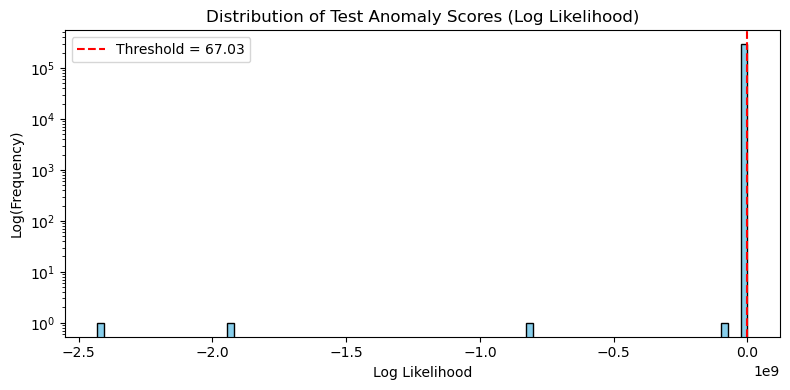

In [4]:
plt.figure(figsize=(8, 4))
plt.hist(test_anomaly_scores, bins=100, color='skyblue', edgecolor='black', log=True)
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.2f}')
plt.title("Distribution of Test Anomaly Scores (Log Likelihood)")
plt.xlabel("Log Likelihood")
plt.ylabel("Log(Frequency)")
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
from sklearn.metrics import classification_report, accuracy_score
from scipy.stats import mode

# Print the simplified classification report on the test data.
print("Classification Report on Test Data (Binary: 0 = Normal, 1 = Attack):")
print(classification_report(y_test_binary, test_anomaly_flags))

Classification Report on Test Data (Binary: 0 = Normal, 1 = Attack):
              precision    recall  f1-score   support

           0       0.90      0.75      0.82    223298
           1       0.48      0.74      0.58     68963

    accuracy                           0.75    292261
   macro avg       0.69      0.74      0.70    292261
weighted avg       0.80      0.75      0.77    292261



Number of samples with label 0 (normal): 223298
Number of samples with label 1 (anomaly): 68963


<Figure size 800x600 with 0 Axes>

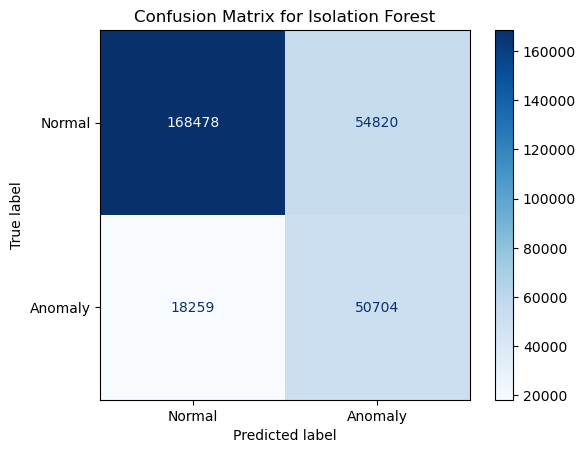

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

print("Number of samples with label 0 (normal):", np.sum(y_test_binary == 0))
print("Number of samples with label 1 (anomaly):", np.sum(y_test_binary == 1))

cm = confusion_matrix(y_test_binary, test_anomaly_flags)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Isolation Forest')
plt.grid(False)
plt.show()

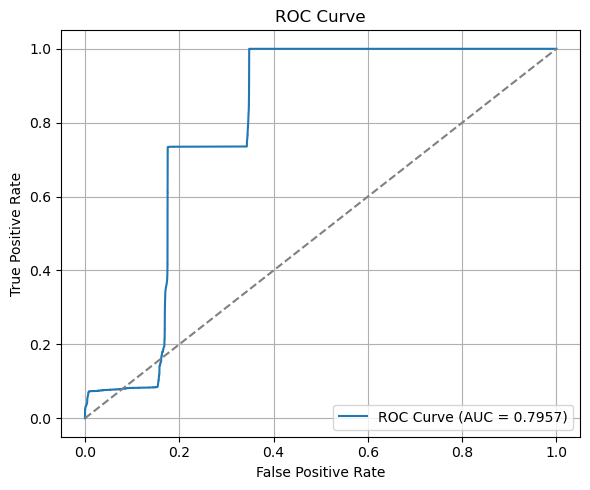

AUC Score: 0.7957


In [7]:
## ROC Curve and AUC Score

from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test_binary, -test_anomaly_scores)  # Negate scores for anomaly = positive
auc_score = roc_auc_score(y_test_binary, -test_anomaly_scores)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"AUC Score: {auc_score:.4f}")